## e006 EDA
 * use quantile

In [1]:
import pandas as pd
import numpy as np
import gc
import pyarrow.parquet as pq
from multiprocessing import Pool
from tqdm import tqdm_notebook as tqdm

import scipy
from scipy import signal
from scipy.signal import butter

from matplotlib import pyplot as plt
import seaborn as sns

import sys
sys.path.append('../../guchio_utils/')

In [2]:
#plt.rcParams['font.family'] = 'IPAPGothic' #全体のフォントを設定
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%config InlineBackend.figure_formats = {'png', 'retina'}
%load_ext autoreload
%autoreload 1

In [16]:
#trn_df = pd.read_parquet('../inputs/origin/train.parquet.zip', compression='zip')
trn_df = pq.read_pandas('../inputs/origin/train.parquet').to_pandas()
trn_meta_df = pd.read_csv('../inputs/origin/metadata_train.csv')

In [21]:
np.percentile(trn_df.iloc[:, :10], 80, axis=0)

array([15., 14., 16., 15., 15., 15., 14., 14., 17., 15.])

In [19]:
trn_df.iloc[:, :10]

,0,1,2,3,4,5,6,7,8,9
0,18,1,-19,-16,-5,19,-15,15,-1,-16
1,18,0,-19,-17,-6,19,-17,16,0,-15
2,17,-1,-20,-17,-6,19,-17,15,-3,-15
3,18,1,-19,-16,-5,20,-16,16,0,-15
4,18,0,-19,-16,-5,20,-17,16,-2,-14
5,18,0,-20,-15,-4,20,-16,15,-2,-12
6,19,1,-18,-16,-5,20,-16,16,-1,-13
7,18,0,-19,-17,-7,18,-17,15,-2,-15
8,18,0,-20,-18,-7,18,-16,15,-2,-16
9,17,0,-19,-17,-7,18,-17,17,-1,-14


In [3]:
trn_hp_dn_df = pd.read_pickle('../inputs/prep/train_hp_dn.pkl.gz', compression='gzip')
trn_hp_dn_df

,0,1,2,3,4,5,6,7,8,9,...,8702,8703,8704,8705,8706,8707,8708,8709,8710,8711
0,13.601562,0.000906,-14.601562,-14.359375,-4.300781,17.921875,-8.484375,6.421875,-0.000802,-13.218750,...,15.773438,-17.171875,10.335938,6.441406,11.609375,3.173828,-20.593750,-13.429688,-6.679688,17.515625
1,16.234375,0.000906,-17.515625,-17.390625,-5.820312,21.062500,-9.898438,9.070312,-0.000802,-15.539062,...,18.187500,-21.968750,12.976562,7.500000,14.734375,4.218750,-18.437500,-16.000000,-7.945312,22.015625
2,11.335938,0.000906,-12.445312,-14.546875,-4.878906,18.562500,-11.429688,12.156250,-0.000802,-12.531250,...,14.906250,-17.859375,11.609375,5.574219,13.398438,5.417969,-17.937500,-13.179688,-5.648438,20.375000
3,12.453125,0.000906,-13.718750,-14.234375,-4.585938,18.843750,-12.609375,14.265625,-0.000802,-11.726562,...,14.937500,-18.078125,11.570312,6.031250,13.648438,6.257812,-16.890625,-13.085938,-6.136719,21.187500
4,17.343750,0.000906,-18.937500,-13.914062,-3.957031,19.437500,-13.406250,15.304688,-0.000802,-11.187500,...,15.960938,-19.500000,11.343750,7.976562,13.796875,6.699219,-17.671875,-13.539062,-8.343750,21.234375
5,18.375000,0.000906,-20.031250,-14.054688,-4.296875,18.796875,-14.039062,15.921875,-0.000802,-11.875000,...,15.968750,-19.625000,10.929688,8.375000,13.406250,6.980469,-17.765625,-13.343750,-8.679688,20.781250
6,17.296875,0.000906,-18.843750,-15.898438,-6.062500,18.078125,-14.375000,15.710938,-0.000802,-14.914062,...,16.234375,-20.171875,10.992188,7.929688,13.187500,6.953125,-18.812500,-13.617188,-7.976562,20.828125
7,17.312500,0.000906,-18.828125,-15.992188,-6.296875,17.390625,-14.664062,15.617188,-0.000802,-15.335938,...,16.062500,-20.062500,10.585938,7.933594,12.656250,6.960938,-18.796875,-13.234375,-7.761719,20.359375
8,17.531250,0.000906,-19.031250,-14.703125,-5.269531,16.843750,-14.914062,15.679688,-0.000802,-13.445312,...,15.421875,-19.343750,9.929688,8.023438,11.960938,7.007812,-17.828125,-12.265625,-7.601562,19.765625
9,16.953125,0.000906,-18.343750,-14.640625,-4.890625,17.015625,-14.882812,15.101562,-0.000803,-12.648438,...,15.398438,-19.484375,9.906250,7.785156,11.765625,6.816406,-17.953125,-11.960938,-7.007812,20.125000


(<matplotlib.axes._subplots.AxesSubplot at 0x7ff6bff5c518>,
 2.1219253540039062e-05,
 8.273124694824219e-05,
 0.00027179718017578125,
 0.00041675567626953125,
 0.775390625,
 18.078127968738045)

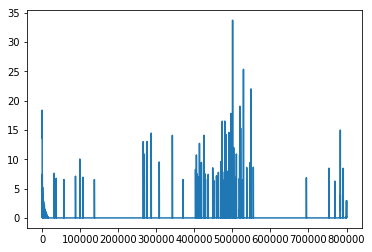

In [4]:
plt_series = trn_hp_dn_df.iloc[:, 0].abs()
plt_series.plot(), np.percentile(plt_series, 70), np.percentile(plt_series, 80), np.percentile(plt_series, 90), np.percentile(plt_series, 95), np.percentile(plt_series, 99), np.percentile(plt_series, 99.999)

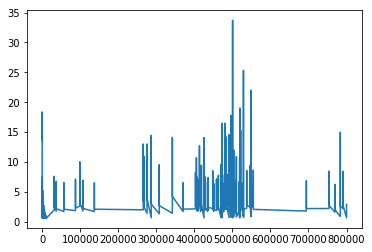

In [11]:
plt_series[(plt_series.abs() > plt_series.astype('float64').abs().std() * 2)].plot()

In [19]:
trn_meta_df.query('target == 1')

,signal_id,id_measurement,phase,target
3,3,1,0,1
4,4,1,1,1
5,5,1,2,1
201,201,67,0,1
202,202,67,1,1
228,228,76,0,1
229,229,76,1,1
230,230,76,2,1
270,270,90,0,1
271,271,90,1,1


(<matplotlib.axes._subplots.AxesSubplot at 0x7ff6bf2d8358>,
 0.2288818359375,
 0.284912109375,
 0.449462890625,
 0.666015625,
 1.1884765625,
 17.859382343720426)

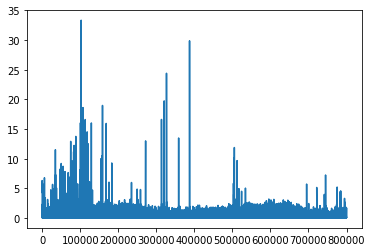

In [18]:
plt_series = trn_hp_dn_df.iloc[:, 4].abs()
plt_series.plot(), np.percentile(plt_series, 70), np.percentile(plt_series, 80), np.percentile(plt_series, 90), np.percentile(plt_series, 95), np.percentile(plt_series, 99), np.percentile(plt_series, 99.999)

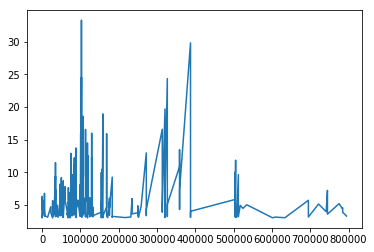

In [23]:
plt_series = trn_hp_dn_df.iloc[:, 4].abs()
plt_series[plt_series > 3].plot()

In [27]:
np.percentile(plt_series, 10)

0.028594970703125

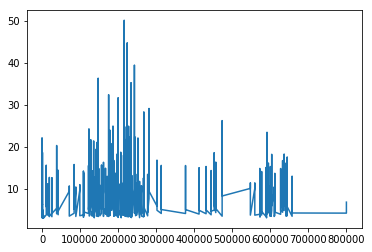

In [21]:
plt_series = trn_hp_dn_df.iloc[:, 201].abs()
plt_series[plt_series > 3].plot()

In [30]:
np.percentile(trn_hp_dn_df.iloc[:, :2], 10, axis=0)

array([-2.17556953e-05, -2.59876251e-05])